### Core

In [6]:
# Header
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
from torchmetrics import Accuracy , ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from timeit import default_timer as timer
import random
from sklearn.model_selection import train_test_split
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# functions
def tensorprint(tensor):
    print("Shape: " , tensor.shape, " , Dimension: ", tensor.ndim , " \nDtype: ", tensor.dtype, " , Device: ", tensor.device)
    print("Max: ", tensor.amax(),f'[{tensor.argmax()}]', " , Min: ", tensor.amin(),f'[{tensor.argmin()}]')
    print(tensor ,'\n')

def torch_rng():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

def print_time(start,end,device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def eval_model(model: torch.nn.Module, 
                dataloader:torch.utils.data.DataLoader, 
                loss_fn:torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):        
    """Returns a dictionary containing result of model predicting on dataloader."""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc+= accuracy_fn(y,y_pred.argmax(dim=1))
        loss /= len(dataloader)
        acc /= len(dataloader)    

    return {"model_name":model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}

def train_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
    """Performs training on dataloader."""
    train_loss, train_acc = 0,0
    model.train()
    for X,y in dataloader:
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"\nTrain loss: {train_loss:.4f} | Train acc: {train_acc:.2f}")

def test_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):
    """Performs testing on dataloader."""
    test_loss, test_acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred,y)
            test_acc += accuracy_fn(y,test_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    print(f"\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")

def make_predictions(model: torch.nn.Module,
                        data:list,
                        device : torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for i in data:
            sample = i.unsqueeze(dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
        
    return torch.stack(pred_probs)
            

### Computer Vision Fundamentals

In [8]:
# Create A Dataset
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform=torchvision.transforms.ToTensor(),
    target_transform= None
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download= True,
    transform=torchvision.transforms.ToTensor(),
    target_transform= None
)
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

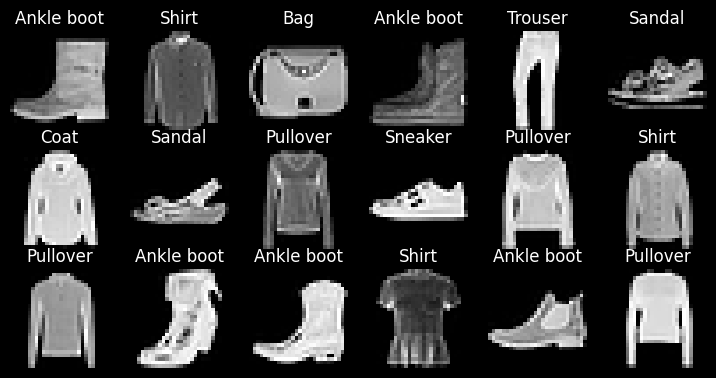

In [9]:
# Properties of Dataset
image, label = train_data[0]

class_names = train_data.classes
class_to_idx = train_data.class_to_idx
train_target = train_data.targets
#tensorprint(image)

fig = plt.figure(figsize=(9,9))
torch_rng()
for i in range(1, 19):
    random_idx = torch.randint(0,len(train_data), size =[1]).item()
    img , label = train_data[random_idx]
    fig.add_subplot(6,6,i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

train:  1875  test:  313


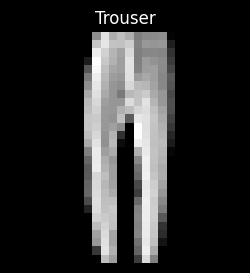

In [10]:
# Properties of Dataloader

BATCH_SIZE =32
# length of image  = 60k 
# length of dataloader = 60k / BATCH_SIZE = 1875
# dataloader = img, label
# img = 32 of 1875 
# label = 32 of 9

train_dataloader = DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

train_features_batch , train_labels_batch = next(iter(train_dataloader))

random_idx = torch.randint(0,len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print("train: ", len(train_dataloader), " test: ",len(test_dataloader))

### Baseline Models

In [ ]:
# Creating a flatten layer
flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x)              # do forward pass/ [1,28,28] -> 784 = 28*28
tensorprint(output)

In [ ]:
# Build a baseline model

class FashionMNISTModelv1(nn.Module):
    def __init__(self, input, output, hidden) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input, out_features=hidden),
            nn.Linear(in_features=hidden, out_features=hidden),
            nn.Linear(in_features=hidden, out_features=output)
        )

    def forward(self,x):
        return self.layer_stack(x)

torch_rng()
model_3 = FashionMNISTModelv1(
    input= 784,                                     # flatten layer = 28*28
    output= len(class_names),                       # one for each differetiate
    hidden=32                                        # hidden layers
)

dummy_x = torch.rand([1,1,28,28])
parameter = model_3.state_dict()
pred = model_3(dummy_x)
pred

In [ ]:
# Training baseline model
torch_rng()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr = 0.1)

start = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    train_loss = 0
    
    # train for each batch = length , X = img , y = Label
    for batch, (X,y) in enumerate(train_dataloader):
        model_3.train()

        y_pred = model_3(X)
        loss = loss_fn(y_pred, y)                     # Calculate -
        train_loss += loss                            # - loss per batch
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # train loss average per batch
    train_loss /= len(train_dataloader)

    # Testing
    test_loss , test_acc = 0, 0
    model_3.eval()

    # test in test_dataloader
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            test_pred = model_3(X_test)
            test_loss += loss_fn(test_pred,y_test)
            test_acc += accuracy_fn(y_test,test_pred.argmax(dim=1))

        # test loss & acc average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

end = timer()
print_time(start,end,str(next(model_3.parameters()).device))        

In [ ]:
# Build model GPU, Non-linear

class FashionMNISTModelv2(nn.Module):
    def __init__(self,input, output,hidden) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=output),
        )
    def forward(self, x):
        return self.layer_stack(x)

torch_rng()
model_3v2 = FashionMNISTModelv2(
    input= 784,                                     # flatten layer = 28*28
    output= len(class_names),                       # one for each differetiate
    hidden=8                                        # hidden units
).to(device)
parameterv2 = model_3v2.state_dict()

In [ ]:
# Train model GPU, non-linear

torch_rng()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3v2.parameters(),lr = 0.1)

start = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    train_step(model_3v2,train_dataloader,loss_fn,optimizer,accuracy_fn,device)
    test_step(model_3v2,test_dataloader,loss_fn,accuracy_fn,device)
end = timer()
print_time(start,end,device)

### Convolutional Neural Network (CNN)

In [12]:
# Build CNN model

class FashionMNISTModelv3(nn.Module):
    """
    Model architecture created by earlll
    """
    def __init__(self, input, output,hidden) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input,            
                        out_channels=hidden,        
                        kernel_size= 3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*7*7,out_features=output)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch_rng()
model_3v3 = FashionMNISTModelv3(
    input=1,                                            # num of color
    output= len(class_names),                           # num of classification
    hidden=10,                                          # num of layer
).to(device)
parameters = model_3v3.state_dict()
random_image = torch.randn(size=(1,28,28))
model_3v3(random_image.unsqueeze(0).to(device))

torch.Size([1, 10, 14, 14])
torch.Size([1, 10, 7, 7])


tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# Train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3v3.parameters(), lr=0.1)

torch_rng()
start = timer()
epochs = 6
for epoch in tqdm(range(epochs)):
    train_step(model_3v3, train_dataloader,loss_fn,optimizer,accuracy_fn,device)
    test_step(model_3v3,test_dataloader,loss_fn,accuracy_fn,device)
end = timer()
print_time(start,end, device)

In [ ]:
# Predictions 
torch_rng()
y_pred_list = []
model_3v3.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc ="Making Predictons... "):
        X, y = X.to(device), y.to(device)
        y_logit = model_3v3(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim =0).argmax(dim=1)
        y_pred_list.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_pred_list)
tensorprint(y_pred_tensor)

In [ ]:
# Save Model 

# MODEL_PATH = Path("Models")
# MODEL_PATH.mkdir(parents= True, exist_ok =True)
# MODEL_NAME = "01_FashionMNISTModelv3_0.pt"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# torch.save(model_3v3.state_dict(), MODEL_SAVE_PATH)

### Evaluation

In [ ]:
# Evaluation
torch_rng()
model_3_results = eval_model(model_3,test_dataloader,loss_fn,accuracy_fn,"cpu")
model_3v2_results = eval_model(model_3v2,test_dataloader,loss_fn,accuracy_fn)
model_3v3_results = eval_model(model_3v3,test_dataloader,loss_fn,accuracy_fn)
compare = pd.DataFrame([model_3_results, model_3v2_results, model_3v3_results])
plt.figure(figsize=(8,4))
compare.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy%")
plt.ylabel("model")
compare

In [ ]:
# Comparison
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
pred_prob = make_predictions(model_3v3, test_samples)
pred_prob = pred_prob.argmax(dim=1)

for i , sample in enumerate(test_samples):
    plt.subplot(3,3,i+1)
    plt.imshow(sample.squeeze())
    pred_label = class_names[pred_prob[i].item()]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred:{pred_label} | Truth:{truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize = 7, c ='g')
    else:
        plt.title(title_text, fontsize = 7, c='r')
    plt.axis(False)

In [ ]:
# Confusion Matrix
confmat = ConfusionMatrix(task='multiclass',num_classes=len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                        target = test_data.targets)
fix , ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(9,6)
)